## [SEE THIS NOTEBOOK FOR HOW WE DEFINED "SALTINESS"](https://colab.research.google.com/drive/1M8gBDOieb8dcBW4Sr7TKlnlQD1s6-u-V)

# Hacker News Data Processing


In [1]:
from textblob import TextBlob
import bokeh
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import html 
import dask
import re
import dask.dataframe as dd
from tqdm import tqdm_pandas
from tqdm import tqdm_notebook as tqdm
import json

def save_df(df):
    df.to_pickle('data/df_save.pkl')
    print('Dataframe Saved')
    
def load_df():
    df = pd.read_pickle('data/df_save.pkl')
    print('Dataframe Loaded')
    return df

# Load TQDM
tqdm_pandas(tqdm())

# Load the profiler into Jupyter notebook
%load_ext line_profiler

## Part A. Get the data.

### Ran the query in Google BigQuery and copied the files to Google Cloud Storage

Then I moved my query data to Google Cloud Storage, downloaded it via the Jupyter Terminal onto my notebook server. 

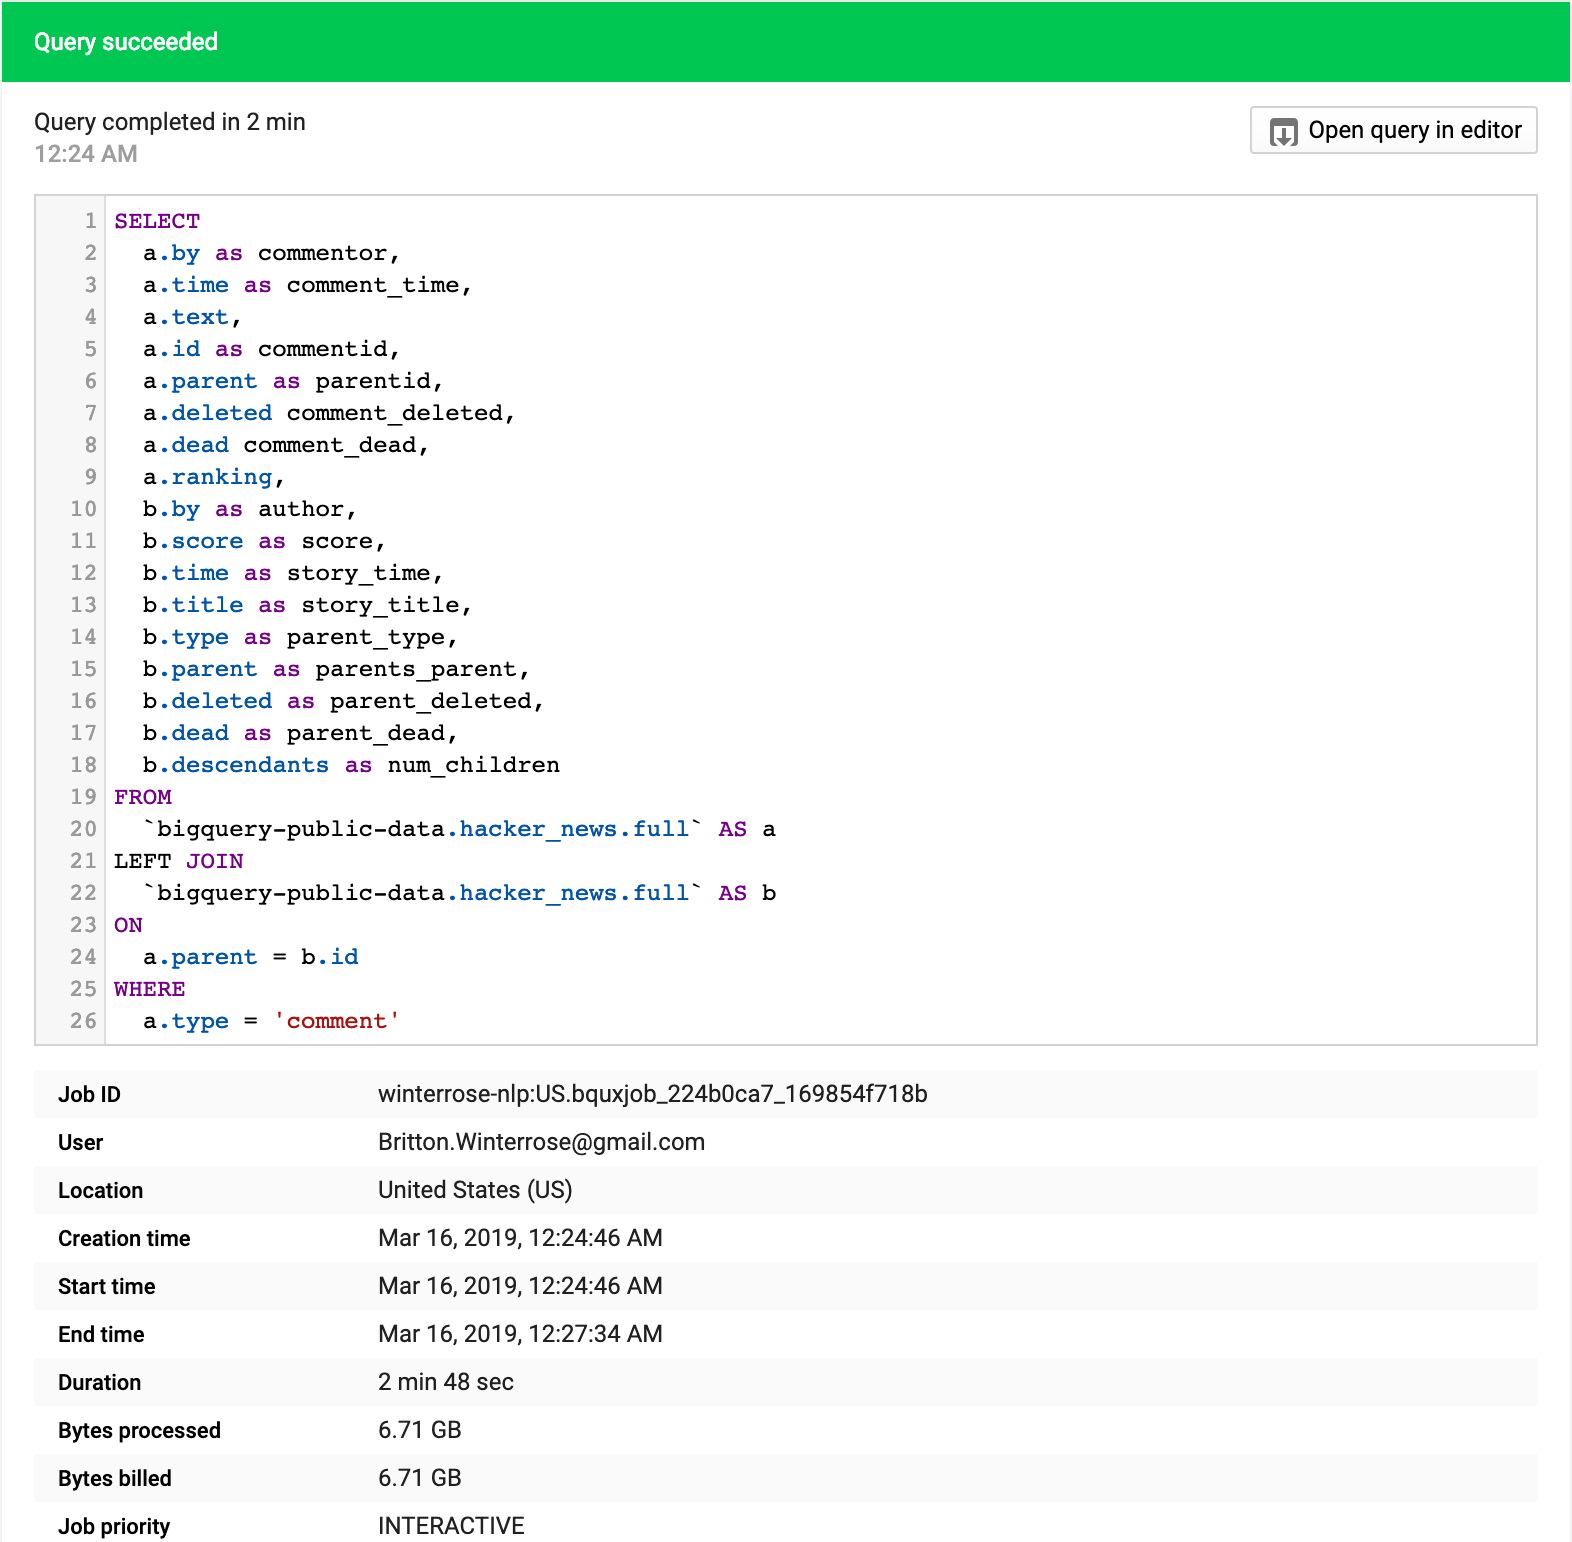

### Dask is giving me errors when I tried to .read( `*.csv` ). Manual approach:

In [2]:
%%time
#dask kept giving me errors. 
d0 = pd.read_csv('data/hn_main_query/hacker_news_full_comments0.csv',engine='python')
print("dataframe1")
d1 = pd.read_csv('data/hn_main_query/hacker_news_full_comments1.csv',engine='python')
print("dataframe2")
d2 = pd.read_csv('data/hn_main_query/hacker_news_full_comments2.csv',engine='python')
print("dataframe3")
d3 = pd.read_csv('data/hn_main_query/hacker_news_full_comments3.csv',engine='python')
print("dataframe4")
d4 = pd.read_csv('data/hn_main_query/hacker_news_full_comments4.csv',engine='python')
print("dataframe5")
d5 = pd.read_csv('data/hn_main_query/hacker_news_full_comments5.csv',engine='python')
print("dataframe6")
d6 = pd.read_csv('data/hn_main_query/hacker_news_full_comments6.csv',engine='python')
print("dataframe7")
d7 = pd.read_csv('data/hn_main_query/hacker_news_full_comments7.csv',engine='python')
print("dataframe8")
d8 = pd.read_csv('data/hn_main_query/hacker_news_full_comments8.csv',engine='python')
print("dataframe9")
d9 = pd.read_csv('data/hn_main_query/hacker_news_full_comments9.csv',engine='python')

dataframe1
dataframe2
dataframe3
dataframe4
dataframe5
dataframe6
dataframe7
dataframe8
dataframe9
CPU times: user 5min 39s, sys: 14.1 s, total: 5min 54s
Wall time: 4min 52s


In [3]:
%%time
df = pd.concat([d0, d1, d2, d3, d4, d5, d6, d7, d8, d9])

CPU times: user 50.2 s, sys: 4.67 s, total: 54.8 s
Wall time: 11.4 s


### Inspect shape of concatenated csv import. Verify that all rows are present. (15,825,859) 

In [4]:
display(df.shape)
display(df.head(10))

(15825859, 17)

,commentor,comment_time,text,commentid,parentid,comment_deleted,comment_dead,ranking,author,score,story_time,story_title,parent_type,parents_parent,parent_deleted,parent_dead,num_children
0,Twisell,1548920587,How come this is already gone from the front p...,19043154,19035834,NaN,NaN,NaN,epaga,731.0,1.548862e+09,Apple blocks Facebook from running its interna...,story,NaN,NaN,NaN,308.0
1,camus2,1396456650,You could still maintain a level of compatibil...,7516784,7516418,NaN,NaN,NaN,kelvin0,NaN,1.396454e+09,NaN,comment,7515297.0,NaN,NaN,NaN
2,acqq,1524697885,"Just that word wouldn&#x27;t be unambiguous, e...",16927263,16923511,NaN,NaN,NaN,celticninja,NaN,1.524675e+09,NaN,comment,16920528.0,NaN,NaN,NaN
3,aestra,1392397390,I had a friend call the paramedics from home w...,7239514,7234721,NaN,NaN,NaN,taybin,NaN,1.392329e+09,NaN,comment,7234703.0,NaN,NaN,NaN
4,AnimalMuppet,1459789890,You don&#x27;t see a difference in whether or ...,11423531,11422828,NaN,NaN,NaN,aantix,NaN,1.459785e+09,NaN,comment,11422692.0,NaN,NaN,NaN
5,walshemj,1441142042,What with one of Tommy Flowers colleagues movi...,10155794,10152729,NaN,NaN,NaN,zeveb,NaN,1.441119e+09,NaN,comment,10152484.0,NaN,NaN,NaN
6,acgourley,1389287479,App store review times? It&#x27;s generally 5 ...,7031649,7029685,NaN,NaN,NaN,oe,NaN,1.389263e+09,NaN,comment,7029656.0,NaN,NaN,NaN
7,dang,1447809451,"Quite a few have hit HN: <a href=""https:&#x2F;...",10585266,10584911,NaN,NaN,NaN,BeefySwain,NaN,1.447805e+09,NaN,comment,10574900.0,NaN,NaN,NaN
8,lewis500,1531764004,Yeah all I see here is incoherent posturing.<p...,17543424,17543252,NaN,NaN,NaN,aeleos,NaN,1.531763e+09,NaN,comment,17542699.0,NaN,NaN,NaN
9,coldpie,1444395265,"So, use an open source one.",10359666,10359613,NaN,NaN,NaN,colinplamondon,NaN,1.444395e+09,NaN,comment,10359491.0,NaN,NaN,NaN


### Remove all  `author` and `text` NaN rows from Dataframe. 

In [5]:
nans = df.text.isna().sum()
print('This many nans:', nans)
df = df.dropna(subset=['commentor', 'text'])
print('New Shape after nan removal:', df.shape)

nans = df.parent_type.isna().sum()
print('This many parent_type nans:', nans)
nans = df.story_title.isna().sum()
print('This many story_title nans:', nans)

This many nans: 428547
New Shape after nan removal: (15397309, 17)
This many parent_type nans: 0
This many story_title nans: 11238756


### Fill in empty `parent_titles` for each comment. 

In [6]:
%%time
df['story_title'] = df.story_title.fillna('Another Comment')
nans = df.story_title.isna().sum()
print('This many story_title nans:', nans)
display(df.head(3))

This many story_title nans: 0


,commentor,comment_time,text,commentid,parentid,comment_deleted,comment_dead,ranking,author,score,story_time,story_title,parent_type,parents_parent,parent_deleted,parent_dead,num_children
0,Twisell,1548920587,How come this is already gone from the front p...,19043154,19035834,NaN,NaN,NaN,epaga,731.0,1.548862e+09,Apple blocks Facebook from running its interna...,story,NaN,NaN,NaN,308.0
1,camus2,1396456650,You could still maintain a level of compatibil...,7516784,7516418,NaN,NaN,NaN,kelvin0,NaN,1.396454e+09,Another Comment,comment,7515297.0,NaN,NaN,NaN
2,acqq,1524697885,"Just that word wouldn&#x27;t be unambiguous, e...",16927263,16923511,NaN,NaN,NaN,celticninja,NaN,1.524675e+09,Another Comment,comment,16920528.0,NaN,NaN,NaN


CPU times: user 17.9 s, sys: 296 ms, total: 18.2 s
Wall time: 4.41 s


## Part B. Apply Sentiment Analysis and more Text Cleaning

### Define utility functions

In [7]:
def encode_decode(text):
    """Utility function to clean text by decoding HTML text."""
    unescaped = html.unescape(text)
    return unescaped


def noHTML(text):
    """Utility function to clean text by removing HTML flags."""
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', text)
    return cleantext


def noURLS(text):
    """Utility function to clean text by removing links using simple regex."""
    return ''.join(re.sub(r"http\S+", "", text))


def get_sentiment(text):
    """Evaluates the sentiment of given text.
    
    Utility function to classify sentiment of passed text
    using textblob's sentiment method. Return the polarity
    score as a float within the range [-1.0, 1.0]
    
    Polarity score is a float within the range [-1.0, 1.0] 
    where negative value indicates negative text 
    and positive value indicates that the given 
    text is positive.

    Subjectivity is a float within the range [0.0, 1.0] 
    where 0.0 is very objective and 1.0 is very subjective.
    
    Args:
        text: the text of a comment.
    
    Returns:
        polarity
        subjectivity
    """
    analysis = TextBlob(text).sentiment
    polarity = analysis.polarity
    subjectivity = analysis.subjectivity
    return polarity, subjectivity



### Apply text cleaning to comment texts and create new column in Dataframe

In [ ]:
df['cleaned_comment'] = df.text.progress_apply(lambda x: noURLS(noHTML(encode_decode(x))))
df['cleaned_title'] = df.story_title.progress_apply(lambda x: noURLS(noHTML(encode_decode(x))))

### Apply sentiment analysis (TextBlob.polarity) to each cleaned Comment text. 

In [15]:
df['comment_sentiment'] = df.cleaned_comment.progress_apply(get_sentiment)
df.iloc[:, -6:].head(3)

,parent_deleted,parent_dead,num_children,cleaned_comment,cleaned_title,comment_sentiment
0,NaN,NaN,308.0,How come this is already gone from the front p...,Apple blocks Facebook from running its interna...,"(0.0, 0.0)"
1,NaN,NaN,NaN,You could still maintain a level of compatibil...,Another Comment,"(0.10833333333333334, 0.6395833333333334)"
2,NaN,NaN,NaN,"Just that word wouldn't be unambiguous, e.g. (...",Another Comment,"(-0.4, 0.6)"


### Drop the original *uncleaned* columns

In [16]:
df = df.drop(columns=['text', 'story_title'])

### Split the comment sentiment tuple into `polarity` and `subjectivity` then replace `comment sentiment`

In [18]:
%%time
alt_df = pd.DataFrame(df['comment_sentiment'].tolist(), index=df.index)
alt_df.columns = ['polarity', 'subjectivity']
df["comment_polarity"] = alt_df.polarity
df["comment_subjectivity"] = alt_df.subjectivity
df = df.drop(columns=['comment_sentiment'])
df.head(3)

CPU times: user 19.9 s, sys: 7.86 s, total: 27.8 s
Wall time: 8.24 s


In [19]:
%%time
df.to_csv('data/hn_all_w_sentiment_cleaned_inplace.csv',index=False)

CPU times: user 5min 20s, sys: 7.5 s, total: 5min 27s
Wall time: 5min 28s


## Part C.  Load cleaned / analyzed data back into dataframe from CSV

In [20]:
%%time
# IMPORT FROM CSV's
df_load = pd.read_csv('data/hn_all_w_sentiment_cleaned_inplace.csv')
print(df_load.shape)

(15397309, 19)
CPU times: user 1min 42s, sys: 11.2 s, total: 1min 53s
Wall time: 1min 43s


### Do some Data Cleanup

In [23]:
%%time
nans = df.comment_deleted.isna().sum()
print('This many nans:', nans)
nans = df.comment_dead.isna().sum()
print('This many nans:', nans)
nans = df.parent_deleted.isna().sum()
print('This many nans:', nans)
nans = df.parent_dead.isna().sum()
print('This many nans:', nans)

df['comment_deleted'] = df.comment_deleted.fillna(value=False)
df['comment_dead'] = df.comment_dead.fillna(value=False)
df['parent_deleted']  = df.parent_deleted.fillna(value=False)
df['parent_dead']  = df.parent_dead.fillna(value=False)


This many nans: 15397309
This many nans: 15202774
This many nans: 15370200
This many nans: 15274890
CPU times: user 1min 52s, sys: 3.65 s, total: 1min 55s
Wall time: 29.4 s


In [24]:
%%time
nans = df.comment_deleted.isna().sum()
print('This many comment_deleted nans:', nans)
nans = df.comment_dead.isna().sum()
print('This many comment_dead nans:', nans)
nans = df.parent_deleted.isna().sum()
print('This many parent_deleted nans:', nans)
nans = df.parent_dead.isna().sum()
print('This many parent_dead nans:', nans)
nans = df.ranking.isna().sum()
print('This many ranking nans:', nans)

This many comment_deleted nans: 0
This many comment_dead nans: 0
This many parent_deleted nans: 0
This many parent_dead nans: 0
This many ranking nans: 15397309
CPU times: user 27.7 s, sys: 118 ms, total: 27.9 s
Wall time: 1.45 s


### Oops, looks like `ranking` column was actually empty for each `comment` on that BigQuery `full` table. I'll need to pull it in from a different table and merge it here by commentid from the comments table. 

After a bit of investigation I found that the table `bigquery-public-data.hacker_news.full_201510` does contain `comment_ranking` type entries, but the `bigquery-public-data.hacker_news.full` (the one that is continuously updated) does not. 

I'm going to add in the comment_ranking data as a column, but not calculate any summary stats off it for the API. 

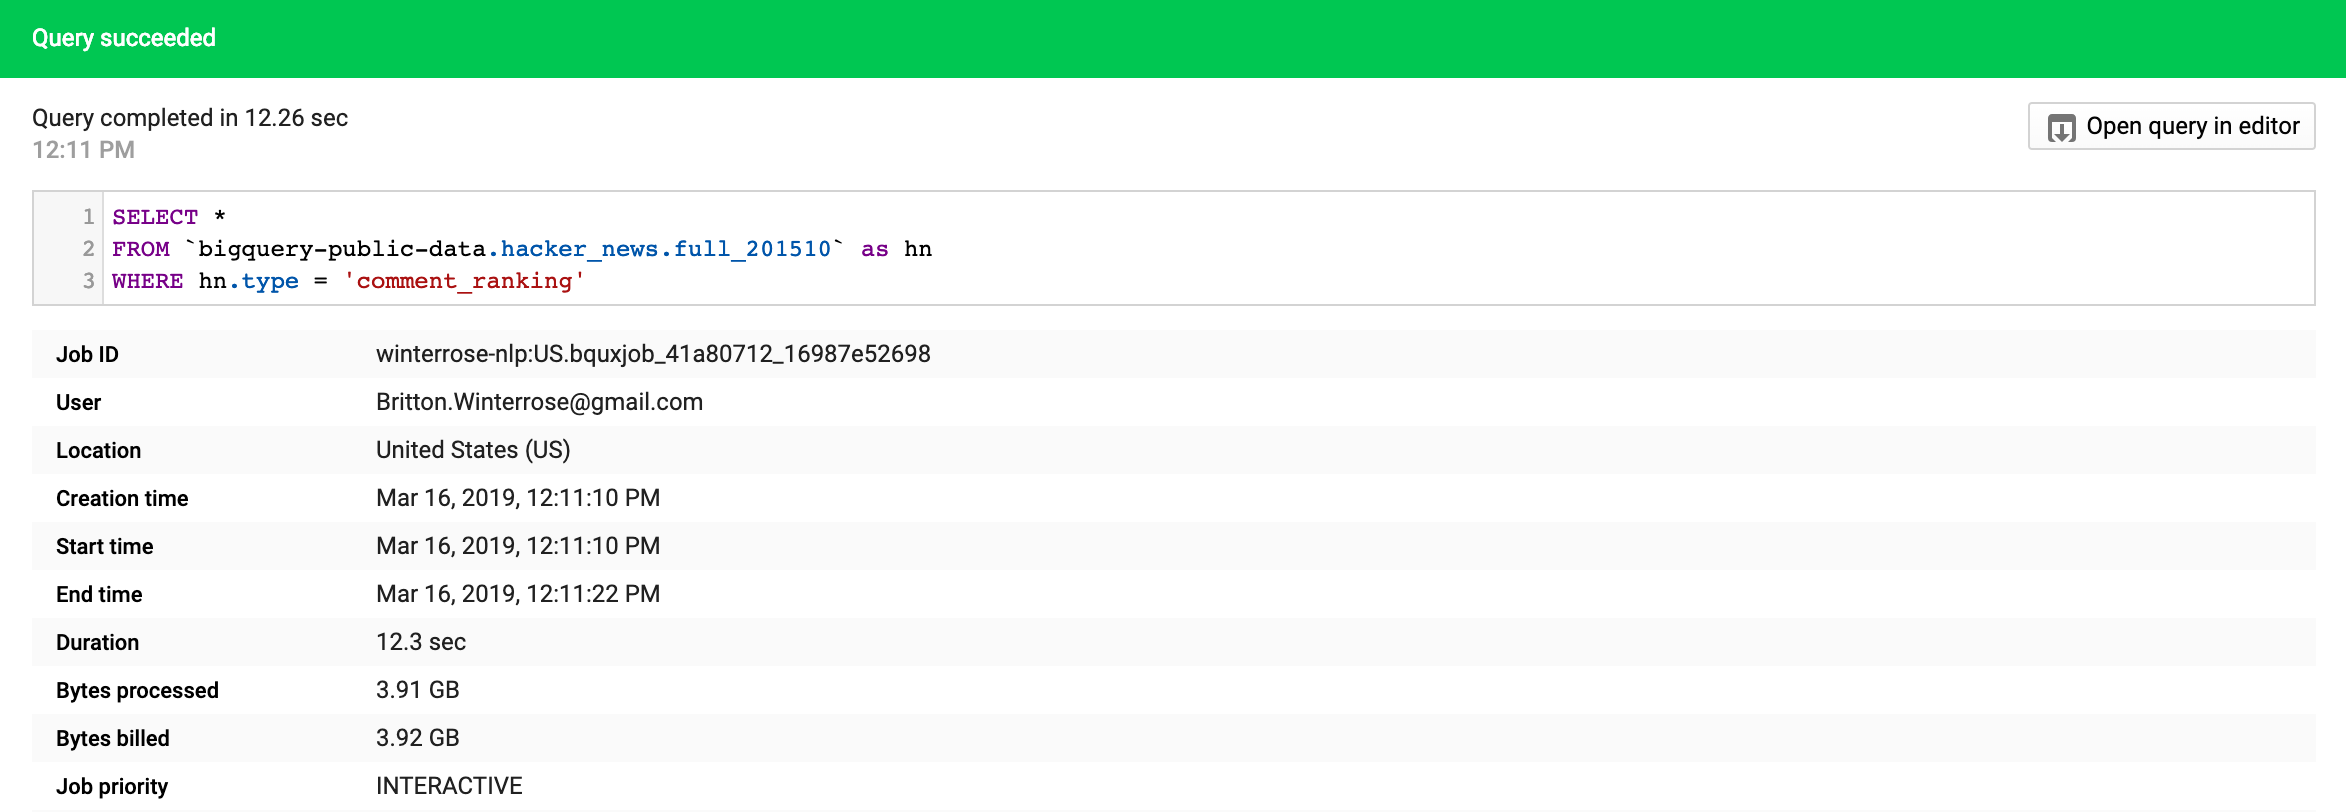

In [25]:
%%time
comment_ranking_df = pd.read_csv("data/hn_comment_ranking_query.csv")
comment_ranking_df = comment_ranking_df[['id','ranking']].copy()
comment_ranking_df.set_index('id')
comment_ranking_df.head(3)

CPU times: user 14 s, sys: 4.21 s, total: 18.2 s
Wall time: 5.82 s


### Add in the missing `ranking` data

In [26]:
%%time
df = df.drop(columns=['ranking'])
df = df.merge(comment_ranking_df, how='left', left_on='commentid', 
              right_on='id')

CPU times: user 34.2 s, sys: 5.86 s, total: 40 s
Wall time: 32.3 s


In [27]:
nans = df.ranking.isna().sum()
print('This many ranking nans:', nans)
print(df.columns)

This many ranking nans: 7226283
Index(['commentor', 'comment_time', 'commentid', 'parentid', 'comment_deleted',
       'comment_dead', 'author', 'score', 'story_time', 'parent_type',
       'parents_parent', 'parent_deleted', 'parent_dead', 'num_children',
       'cleaned_comment', 'cleaned_title', 'comment_polarity',
       'comment_subjectivity', 'id', 'ranking'],
      dtype='object')


## Part D.  Make some features to aid in the final stat aggregation.

### Fill Nan's and rename columns so API (JSON) is easier to read. 

In [28]:
%%time
df = df.fillna(value=0)
df = df.rename(columns={'author': 'parent_author', 
                        'cleaned_title': 'parent_title',
                        'score': 'parent_score', 
                        'story_time': 'parent_time', 
                        'ranking': 'comment_rank',
                        'commentid':'comment_id',
                        'parentid':'parent_id'})

df = df.drop(columns=['id'])
df = df.sort_values(by = ['comment_subjectivity','comment_polarity'])
display(df.head(3))
display(df.tail(3))

,commentor,comment_time,comment_id,parent_id,comment_deleted,comment_dead,parent_author,parent_score,parent_time,parent_type,parents_parent,parent_deleted,parent_dead,num_children,cleaned_comment,parent_title,comment_polarity,comment_subjectivity,comment_rank
5449963,Allocator2008,1242652127,614896,614712,False,True,mstevens,59.0,1.242642e+09,story,0.0,False,False,20.0,"OMG, they killed Kenny!!! You bastards!!!",The Death of Richard Dawkins: A short story by...,-0.762939,0.0,8.0
6244275,pankajdoharey,1506373773,15334179,15332819,False,True,GuiA,1174.0,1.506364e+09,story,0.0,False,False,618.0,Stan : OH My GOD - they Killed Whatsapp!! Kyle...,China Blocks WhatsApp,-0.610352,0.0,0.0
4331859,eyeJam,1424278947,9069538,9069282,False,False,coldcode,11.0,1.424277e+09,story,0.0,False,False,3.0,"""making his prior investment in his theater de...",Tulsa University Bans Student from Campus for ...,-0.500000,0.0,2.0


,commentor,comment_time,comment_id,parent_id,comment_deleted,comment_dead,parent_author,parent_score,parent_time,parent_type,parents_parent,parent_deleted,parent_dead,num_children,cleaned_comment,parent_title,comment_polarity,comment_subjectivity,comment_rank
15396247,Porter_423,1335509610,3897919,3897723,False,True,paulgerhardt,68.0,1.335505e+09,story,0.0,False,False,12.0,simply awesome,"31 Years Later, ""Star Castle"" Finally Ported t...",1.0,1.0,5.0
15396324,caseorganic,1356906450,4987376,4987309,False,False,kyledrake,13.0,1.356905e+09,story,0.0,False,False,3.0,Somewhere Street is awesome and a bit like pla...,"Show HN: Interesting documentaries from Japan,...",1.0,1.0,0.0
15396875,ac360,1425005188,9116906,9116331,False,False,inglor,225.0,1.424994e+09,story,0.0,False,False,77.0,Why reconcile? This is awesome competition. ...,Io.js and Node.js reconciliation proposal,1.0,1.0,5.0


CPU times: user 2min 11s, sys: 25.4 s, total: 2min 37s
Wall time: 1min 13s


### Make a copy of the Dataframe to preserve our work incase of error. 

In [47]:
data = df

### Normalize comment subjectivity from sub `-1 to 1` to obj. Create booleans for +/- classes. 

In [48]:
%%time

def sentiment_helpers(df):
    """Creates new columns in the given dataframe
    
    Comment Subjectivity: 
    
        Type:   Float, 0.0 to 1.0, 
        Legend: 0 = Objective, 1 = Subjective 
        Calc:   x = TextBlob(text).sentiment.subjectivity, 
        f(x):   get_sentiment
        Use:    Seperate critisism from saltiness & enthusiasum from support.
                As subjectivity decreases sentiment becomes less personal, 
                more objective. 
        
    Comment Saltiness:
    
        Type:   Float, -1.0 to 0.0 to 1.0, 
        Legend: -1 = Salty,  0 = Neutral,  1 = Enthuisastic
        Calc:   TextBlob(text).sentiment.subjectivity * 
                TextBlob(text).sentiment.polarity
        Use:    Seperate critisism from saltiness & enthusiasum from support.
                As subjectivity decreases sentiment is less personal, 
                more objective. 
    
    Subjectivity_spectrum(Revised): 
    
        Type:   Float,  -1.0 to 1.0, 
        Legend: -1 = Objective, 1 = Subjective 
        Calc:   x = TextBlob(text).sentiment.subjectivity, Negated, center on 
                zero, multiply by 2. 
        f(x):   get_sentiment
        Use:    Seperate critisism from saltiness & enthusiasum from support.
                Used for graphing -1 to 1 Arc & Bar data. 
                As subjectivity decreases sentiment is less personal, 
                more objective.
    
    Boolean Columns: 
        Used for filtering - is_subjective, is_negative, is_salty

    Args:
        df: The full comment dataframe.    
    """
    df['comment_saltiness'] = (df['comment_polarity']
                               .multiply(df['comment_subjectivity']))
    df['subjectivity_spectrum'] = (df['comment_subjectivity'].multiply(-1)
                                   .add(.5).multiply(2))
    df['is_subjective'] = (df['comment_subjectivity']
                           .map(lambda x: True if (x > .5) else False))
    df['is_negative'] = (df['comment_polarity']
                         .map(lambda x: True if (x < 0) else False))
    df['is_salty'] = (df['comment_saltiness']
                      .map(lambda x: True if (x < 0) else False))
    print ("Sentiment helpers created...")


sentiment_helpers(data)


Sentiment helpers created...
CPU times: user 31.7 s, sys: 11.4 ms, total: 31.7 s
Wall time: 9.24 s


In [49]:
%%time
# Should see spectrum from -1 to 1, and saltiness -1 to 0 (from diminishing effect of objectivity). 
data = data.sort_values(by = ['subjectivity_spectrum','comment_saltiness'])
display(data.iloc[:,-6:].head(3))
display(data.iloc[:,-6:].tail(3))

,comment_rank,comment_saltiness,subjectivity_spectrum,is_subjective,is_negative,is_salty
1287,8.0,-1.0,-1.0,True,True,True
4310,0.0,-1.0,-1.0,True,True,True
4607,3.0,-1.0,-1.0,True,True,True


,comment_rank,comment_saltiness,subjectivity_spectrum,is_subjective,is_negative,is_salty
13303123,0.0,0.0,1.0,False,False,False
4723851,2.0,0.0,1.0,False,False,False
2384549,4.0,0.0,1.0,False,False,False


CPU times: user 31 s, sys: 987 ms, total: 32 s
Wall time: 10.1 s


### Create `quadrant` column for categorical class for use in Groupby function.

In [50]:
%%time

def determine_quadrant(df):
    """Calculates Quadrants and creates column. 

    Creates columns for a polarity/subjectivity quadrant type groupby filter.
    Quadrants are as follows:
        `neg_obj` - Critic
        `neg_sub` - Salty
        `pos_obj` - Advocate
        `pos_sub` - Happy 
    
    Args:
        df: The full comment dataframe.

    Returns: 
        df: The same dataframe with added `quadrants` column.
    """
    df['polarity'] = (df['comment_polarity'].map(lambda x:'neg' 
                                                 if (x < 0) else 'pos'))
    df['basis'] = (df['comment_subjectivity'].map(lambda x: 'sub' 
                                                  if (x > .5) else 'obj'))
    df = df.assign(quadrant=[str(x) + '_' + str(y) for x, y
                             in zip(df['polarity'], df['basis'])])
    df = df.drop(columns=['polarity','basis'])
    return df


data = determine_quadrant(data)

CPU times: user 1min 9s, sys: 6.34 s, total: 1min 15s
Wall time: 1min 6s


In [51]:
display(data.shape)
display(data.iloc[0:2, -8:])

(15397309, 25)

,comment_subjectivity,comment_rank,comment_saltiness,subjectivity_spectrum,is_subjective,is_negative,is_salty,quadrant
1287,1.0,8.0,-1.0,-1.0,True,True,True,neg_sub
4310,1.0,0.0,-1.0,-1.0,True,True,True,neg_sub


### Send every row of these columns into a Json string. 

In [52]:
%%time

def create_comment_JSON_records(df):
    """Turns comments + stats into json objects, creates column in given df.
    
    Saves filtered dataframe columns as json object oriented on row records. 
    Decodes the JSON string into a list containing 1 JSON object per row.
    Adds new column in the given dataframe that stores the row's JSON Object.
    
    Args:
        df: The full comment dataframe.    
    """
    saved = (df[['commentor', 'comment_time', 'comment_saltiness',
                 'comment_polarity', 'comment_subjectivity', 
                 'subjectivity_spectrum', 'is_salty', 'is_subjective',
                 'is_negative', 'parent_type', 'parent_author', 'parent_title',
                 'cleaned_comment', 'comment_rank', 'comment_id', 'parent_id']]
             .to_json(orient='records'))
    decoded = json.JSONDecoder().decode(saved)
    df['comment_JSON'] = decoded
    print( "JSON Uploaded")


create_comment_JSON_records(data)

JSON Uploaded
CPU times: user 2min 34s, sys: 19.8 s, total: 2min 53s
Wall time: 2min 53s


In [54]:
display(data.shape)
display(data.iloc[0:2, -6:])

(15397309, 26)

,subjectivity_spectrum,is_subjective,is_negative,is_salty,quadrant,comment_JSON
1287,-1.0,True,True,True,neg_sub,"{'commentor': 'Aloisius', 'comment_time': 1337..."
4310,-1.0,True,True,True,neg_sub,"{'commentor': 'tills13', 'comment_time': 15240..."


In [55]:
data.iloc[3:4].comment_JSON.values

array([{'commentor': 'matznerd', 'comment_time': 1412710731, 'comment_saltiness': -1.0, 'comment_polarity': -1.0, 'comment_subjectivity': 1.0, 'subjectivity_spectrum': -1.0, 'is_salty': True, 'is_subjective': True, 'is_negative': True, 'parent_type': 'comment', 'parent_author': 'dimillian', 'parent_title': 'Another Comment', 'cleaned_comment': 'Please do convert it, I am working on a project with some of your code as a base!', 'comment_rank': 0.0, 'comment_id': 8423483, 'parent_id': 8422941}],
      dtype=object)

### Get a count of how many unique commentors are in this data

In [56]:
%%time
userKeys = data["commentor"]
ukeys, index = np.unique(userKeys, True)
display(ukeys.shape)

(388120,)

CPU times: user 34.8 s, sys: 155 ms, total: 34.9 s
Wall time: 34.8 s


### Export a Sample of our data to compare polarity vs saltiness to see how it effects the spread.

Doing this to gut-check our assumptions of how our calculated metric `saltiness` will function. 
(*See link at top of notebook.*) 

In [57]:
data_sample = data[['comment_polarity','comment_saltiness',
                    'comment_subjectivity','is_subjective','is_negative',
                    'is_salty','quadrant']].sample(n=100000, random_state=42)

data_sample.to_pickle('data/polarity_salty_compare.pkl')
print('Dataframe Saved')

Dataframe Saved


## Part E.  Create groupby stats for our selected metrics

### Calculate Commentor `count comments` & `first/latest` comment dates. 

Also create Dataframe_Commentor_Table, `df_ct`.

In [58]:
%%time

def commentor_stats(df):
    """Returns stats about the commentor's comment history 
    
    Groups by `commentor` and calculates agg stats for 'count',`min`, `max`.
    
    Columns Created:
        `count_comments` - count the number of comments.
        `time_of_last_comment`  - Unix Epoch time of the last comment before our
                                  data was pulled on Mar 16, 2019, 12:24:46 AM.
        `time_of_first_comment` - Unix Epoch time of the earliest comment. 
    
    Args:
        df: The full comment dataframe.

    Returns: 
        out: A dataframe with index `commentor` and created columns.
    """
    out = (df.groupby('commentor', as_index=False)['comment_time']
           .agg(['count','max','min']))
    out = out.rename({'count': 'count_comments',
                      'max': 'time_of_last_comment',
                      'min': 'time_of_first_comment'}, axis='columns')
    print("Calculated commentor stats.")
    return out


# Run Function & create df_ct
df_ct = commentor_stats(data)

Calculated commentor stats.
CPU times: user 11.9 s, sys: 405 ms, total: 12.3 s
Wall time: 5.75 s


In [59]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(3))

(388120, 3)

,count_comments,time_of_last_comment,time_of_first_comment
commentor,,,
0-,1,1394798525,1394798525
0--__-_-__--0,1,1541102045,1541102045
0-0,1,1259867712,1259867712


### Group `Count` & `Sum` of the Saltiness Scores by Month for Plotting. Create list of plotpoints for each Commentor. 

In [60]:
%%time

def calculate_monthly_summaries(df):
    """Creates summary of stats over `commentors` history by month for graphing.
    
    Calculates the `count` and `sum` aggregated stats of `comment_saltiness`
    grouped by `is_salty` & `month_text`. 
    Formats the stats into a JSON object for each commenters' period.
    Concatenates JSON Objects into a sequential sparse list (no empty months) 
    for each commentor. 
    
    Stats in the `montly_plot` list are:
        y_m: Year-Month period of stat aggregation from the `month-text` group.
        c_h: Stat, count of Happy Comments for the month.
        c_s: Stat, count of Salty Comments for the month.
        t_h: Stat, total (sum) of Happy Comment Scores for the month.
        t_s: Stat, total (sum) of Salty Comment Scores for the month.
    
    Args:
        df: The full comment dataframe.

    Returns: 
        out: A dataframe with index `commentor`, and a column `monthly_plot`. 
    """
    df['month_text'] = (pd.to_datetime(df['comment_time'],unit='s')
                        .dt.strftime('%Y_%m')).str[-5:]
    
    out = df['comment_saltiness'].groupby([df['commentor'], 
                                           df['month_text'],
                                           df['is_salty']]
                                         ).agg(['count','sum']).unstack()
    
    out.columns = [''.join(str(col)).strip() for col in out.columns.values]
    out = out.rename({"('count', False)": 'c_h', # Count Happy 
                      "('count', True)": 'c_s', # Count Salty
                      "('sum', False)": 't_h', # Sum Happy
                      "('sum', True)": 't_s'}, axis='columns') # Sum Salty 
    print("Calculated monthly stats")
    
    # Combine the monthly_stats into an object. 
    out.reset_index(inplace=True)
    out = out.rename({"month_text": 'y_m'},axis='columns')
    out = out.fillna(0.0)
    out["t_h"] = out["t_h"].round(decimals=2)
    out["t_s"] = out["t_s"].round(decimals=2)
    out_json = (out[["y_m","t_s","t_h","c_s","c_h"]].to_json(orient='records'))
    decoded = json.JSONDecoder().decode(out_json)
    out['monthly_graph'] = decoded
    
    # Combine the montly_stats_object into a list for each commentor.
    out.sort_values(['commentor','y_m'], ascending=[True, True])
    keys, values = out[['commentor', 'monthly_graph']].values.T
    ukeys, index = np.unique(keys, True)
    arrays = np.split(values,index[1:])
    df = pd.DataFrame(data = {'monthly_plot':[list(a) for a in arrays]},
                      index = ukeys)
    print("Created monthly stat lists.")  
    return df


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, calculate_monthly_summaries(data),
                 left_index=True, right_index=True, how='left')

Calculated monthly stats
Created monthly stat lists.
CPU times: user 3min 43s, sys: 5.59 s, total: 3min 49s
Wall time: 2min 2s


In [61]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(5))
display(df_ct.iloc[3:5].monthly_plot.values)

(388120, 4)

,count_comments,time_of_last_comment,time_of_first_comment,monthly_plot
commentor,,,,
0-,1,1394798525,1394798525,"[{'y_m': '14_03', 't_s': 0.0, 't_h': 0.12, 'c_..."
0--__-_-__--0,1,1541102045,1541102045,"[{'y_m': '18_11', 't_s': -0.01, 't_h': 0.0, 'c..."
0-0,1,1259867712,1259867712,"[{'y_m': '09_12', 't_s': -0.28, 't_h': 0.0, 'c..."
0-4,12,1288646410,1288394371,"[{'y_m': '10_10', 't_s': -0.01, 't_h': 0.71, '..."
0-9,2,1524324694,1477669562,"[{'y_m': '16_10', 't_s': 0.0, 't_h': 0.0, 'c_s..."


array([list([{'y_m': '10_10', 't_s': -0.01, 't_h': 0.71, 'c_s': 2.0, 'c_h': 9.0}, {'y_m': '10_11', 't_s': 0.0, 't_h': 0.06, 'c_s': 0.0, 'c_h': 1.0}]),
       list([{'y_m': '16_10', 't_s': 0.0, 't_h': 0.0, 'c_s': 0.0, 'c_h': 1.0}, {'y_m': '18_04', 't_s': 0.0, 't_h': 0.06, 'c_s': 0.0, 'c_h': 1.0}])],
      dtype=object)

### Create the 50 `top_cmnts_s `list for each Commentor - Filter by `is_salty`

In [62]:
%%time 

def top_salty_comments(df):
    """Creates list object for each `commentor` of top 50 saltiest comments. 
    
    Filters by `is_salty` = True.
    Sorts values by `comment_saltiness` from the most salty (lowest value).
    Groups dataframe by `commentor'.
    Concatenates top 50 `comment_JSON` comment objects into a list object.
    Creates a new column from the list of obj(commentor's list of json objects).
    
    Args:
        df: The full comment dataframe.

    Returns: 
        df: A dataframe w/ index `commentor` and a column 'top_cmnts_s'.
    """
    # Grab the right comments, pulls up to 50 comments by saltiest.
    df = df[df['is_salty'] == True]
    df = df.sort_values(['commentor','comment_saltiness'],
                        ascending=[True, True])
    df = (df[['commentor','comment_JSON']].groupby(df['commentor']).head(50)
          .reset_index(drop=True))
    
    # Group the comments into a list for each user.
    keys, values = df.values.T
    ukeys, index = np.unique(keys, True)
    arrays = np.split(values,index[1:])
    df = pd.DataFrame(data = {'top_cmnts_s':[list(a) for a in arrays]},
                      index = ukeys)
    print("Grabbed the SALTIEST comments.")
    return df   


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, top_salty_comments(data),
                 left_index=True, right_index=True, how='left')

Grabbed the SALTIEST comments.
CPU times: user 48.4 s, sys: 51.2 ms, total: 48.5 s
Wall time: 32.2 s


In [63]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(5))

(388120, 5)

,count_comments,time_of_last_comment,time_of_first_comment,monthly_plot,top_cmnts_s
commentor,,,,,
0-,1,1394798525,1394798525,"[{'y_m': '14_03', 't_s': 0.0, 't_h': 0.12, 'c_...",NaN
0--__-_-__--0,1,1541102045,1541102045,"[{'y_m': '18_11', 't_s': -0.01, 't_h': 0.0, 'c...","[{'commentor': '0--__-_-__--0', 'comment_time'..."
0-0,1,1259867712,1259867712,"[{'y_m': '09_12', 't_s': -0.28, 't_h': 0.0, 'c...","[{'commentor': '0-0', 'comment_time': 12598677..."
0-4,12,1288646410,1288394371,"[{'y_m': '10_10', 't_s': -0.01, 't_h': 0.71, '...","[{'commentor': '0-4', 'comment_time': 12883946..."
0-9,2,1524324694,1477669562,"[{'y_m': '16_10', 't_s': 0.0, 't_h': 0.0, 'c_s...",NaN


### Get the `top_salty_comment` for each Commentor - Need it for `Rank` Lists

In [64]:
%%time 

def the_top_salty_comment(df):
    """Returns the top salty comment of each `commentor`. 
    
    Filters by `is_salty`
    Sorts on `commentor` and `comment_saltiness` to bring saltiest to top.
    Groups dataframe by `commentor`. 
    Creates a list containing the top comment for each `commentor`. 
    Turns the list into a new column: `top_salty_comment`
    
    Args:
        df: The full comment dataframe.

    Returns: 
        df: A dataframe w/ index `commentor` and column `top_salty_comment`.
    """
    # Grab the right comments, will pull the top salty comment.
    df = df[df['is_salty'] == True]
    df = df.sort_values(['commentor','comment_saltiness'],
                        ascending=[True, True])
    df = (df[['commentor','comment_JSON']].groupby(df['commentor']).head(1)
          .reset_index(drop=True))
    
    # Group the comments into a list for each user.
    keys, values = df.values.T
    ukeys, index = np.unique(keys, True)
    arrays = np.split(values,index[1:])
    df = pd.DataFrame(data = {'top_salty_comment':[list(a) for a in arrays]},
                      index = ukeys)
    print("Grabbed the top SALTIEST comment.")
    return df   


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, the_top_salty_comment(data),
                 left_index=True, right_index=True, how='left')

Grabbed the top SALTIEST comment.
CPU times: user 30.5 s, sys: 25.9 ms, total: 30.6 s
Wall time: 12.1 s


### Group the top 20 `Happy` Comments for each commentor - Filter by `is_salty`

In [65]:
%%time 

def top_happy_comments(df):  
    """ Creates list object for each `commentor` of their top 50 happy comments. 
    
    Filters by `is_salty` = False 
    Sorts values by `comment_saltiness` from the most happy (highest value).
    Groups dataframe by `commentor'.
    Concatenates top 20 `comment_JSON` comment objects into a list object.
    Creates a new column from the list of obj(commentor's list of json objects).
    
    Args:
        df: The full comment dataframe.

    Returns: 
        df: A dataframe w/ index `commentor` and column `top_cmnts_h`.
    """
    # Grab the right comments, will pull up to 20 comments by happiest.
    df = df[df['is_salty'] == False]
    df = df.sort_values(['commentor','comment_saltiness'],
                        ascending=[True, False])
    df = (df[['commentor','comment_JSON']].groupby(df['commentor']).head(20)
          .reset_index(drop=True))
    
    # Group the comments into a list for each user.
    keys, values = df.values.T
    ukeys, index = np.unique(keys, True)
    arrays = np.split(values,index[1:])
    df = pd.DataFrame(data = {'top_cmnts_h':[list(a) for a in arrays]},
                      index = ukeys)
    print("Grabbed the HAPPIEST comments.")
    return df   


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, top_happy_comments(data),
                 left_index=True, right_index=True, how='left')


Grabbed the HAPPIEST comments.
CPU times: user 1min 27s, sys: 37.7 ms, total: 1min 27s
Wall time: 56.3 s


In [66]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(3))

(388120, 7)

,time_of_last_comment,time_of_first_comment,monthly_plot,top_cmnts_s,top_salty_comment,top_cmnts_h
commentor,,,,,,
0-,1394798525,1394798525,"[{'y_m': '14_03', 't_s': 0.0, 't_h': 0.12, 'c_...",NaN,NaN,"[{'commentor': '0-', 'comment_time': 139479852..."
0--__-_-__--0,1541102045,1541102045,"[{'y_m': '18_11', 't_s': -0.01, 't_h': 0.0, 'c...","[{'commentor': '0--__-_-__--0', 'comment_time'...","[{'commentor': '0--__-_-__--0', 'comment_time'...",NaN
0-0,1259867712,1259867712,"[{'y_m': '09_12', 't_s': -0.28, 't_h': 0.0, 'c...","[{'commentor': '0-0', 'comment_time': 12598677...","[{'commentor': '0-0', 'comment_time': 12598677...",NaN


### Calculate stats for Saltiness - `Overall`

In [67]:
%%time

def saltiness_stats(df):
    """Creates stats of `comment_saltiness` overall.
    
    First groups dataframe by `commentor`. 
    Aggregates `count`, `sum`, & `mean` stats of `comment_saltiness` by `is_salty`.
    Creates new column for each aggregate stat: 4 new columns.
    
    Args:
        df: The full comment dataframe.

    Returns: 
        out: A dataframe with index `commentor`, and a column for each agg.stat.
    """
    out = (df.groupby('commentor', as_index=False)['comment_saltiness']
           .agg(['sum', 'mean', 'min', 'max']))
    out = out.rename({'sum': 'sum_slt_oall',
                      'mean': 'average_slt_oall',
                      'min': 'min_slt_oall',
                      'max': 'max_slt_oall'}, axis='columns')
    print("Calculated saltiness overall stats.")
    return out


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, saltiness_stats(data), left_index=True,
                 right_index=True, how='left')

Calculated saltiness overall stats.
CPU times: user 13.2 s, sys: 0 ns, total: 13.2 s
Wall time: 5.83 s


In [68]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(3))

(388120, 11)

,top_salty_comment,top_cmnts_h,sum_slt_oall,average_slt_oall,min_slt_oall,max_slt_oall
commentor,,,,,,
0-,NaN,"[{'commentor': '0-', 'comment_time': 139479852...",0.120000,0.120000,0.120000,0.120000
0--__-_-__--0,"[{'commentor': '0--__-_-__--0', 'comment_time'...",NaN,-0.006803,-0.006803,-0.006803,-0.006803
0-0,"[{'commentor': '0-0', 'comment_time': 12598677...",NaN,-0.280000,-0.280000,-0.280000,-0.280000


### Calculate stats for Saltiness - Split `Happy/Salty`

In [69]:
%%time

def saltiness_stats_split(df):
    """Creates stats of `comment_saltiness` by `is_salty`. 
    
    First groups dataframe by `commentor`. 
    Aggregates `count`, `sum`, & `mean` stats of `comment_saltiness` by `is_salty`. 
    Creates new column for each aggregate stat: 6 new columns. 
    
    Args:
        df: The full comments dataframe.

    Returns: 
        out: A dataframe with index `commentor`, and a column for each agg.stat.
    """
    out = (df['comment_saltiness'].groupby([df['commentor'],df['is_salty']])
           .agg(['count','sum', 'mean']).unstack())
    out.columns = [''.join(str(col)).strip() for col in out.columns.values]
    out = out.rename({"('count', False)": 'cnt_slt_h',
                      "('count', True)": 'cnt_slt_s',
                      "('sum', False)": 'sum_slt_h',
                      "('sum', True)": 'sum_slt_s',
                      "('mean', False)":"avg_slt_h",
                      "('mean', True)":"avg_slt_s"},
                     axis='columns')
    print("Calculated saltiness grouped stats - split by salty/happy.")
    return out


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, saltiness_stats_split(data), left_index=True,
                 right_index=True, how='left')

Calculated saltiness grouped stats - split by salty/happy.
CPU times: user 41.8 s, sys: 2.3 ms, total: 41.8 s
Wall time: 7.15 s


In [70]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(3))

(388120, 17)

,cnt_slt_h,cnt_slt_s,sum_slt_h,sum_slt_s,avg_slt_h,avg_slt_s
commentor,,,,,,
0-,1.0,NaN,0.12,NaN,0.12,NaN
0--__-_-__--0,NaN,1.0,NaN,-0.006803,NaN,-0.006803
0-0,NaN,1.0,NaN,-0.280000,NaN,-0.280000


### Calculate stats for Saltiness - Split `Quadrant`

In [71]:
%%time

def saltiness_stats_quadrants(df):
    """Creates stats of comment_saltiness by quadrant.
    
    First groups dataframe by `commentor`. 
    Aggregates `sum`, `count`, & `mean` of `comment_saltiness` by `quadrant`.
    Creates new column for each aggregate stat: 12 new columns.
    
    Quadrants are as follows:
        `neg_obj` - Critic
        `neg_sub` - Salty
        `pos_obj` - Advocate
        `pos_sub` - Happy 
    
    Args:
        df: The full-comment dataframe.

    Returns: 
        out: A dataframe with index `commentor`, and a column for each agg.stat.
    """
    out = (df['comment_saltiness'].groupby([df['commentor'],df['quadrant']])
           .agg(['sum', 'mean', 'count']).unstack())
    out = out.rename({"sum": 'sum_slt',"mean":"avg_slt",
                      'count':"cnt_slt"},axis='columns')
    out.columns = ['_'.join(col).strip() for col in out.columns.values]
    print("Calculated saltiness quadrant stats.")
    return out


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, saltiness_stats_quadrants(data), left_index=True,
                 right_index=True, how='left')

Calculated saltiness quadrant stats.
CPU times: user 49.6 s, sys: 11.6 ms, total: 49.6 s
Wall time: 8.27 s


In [72]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(3))

(388120, 29)

,avg_slt_pos_obj,avg_slt_pos_sub,cnt_slt_neg_obj,cnt_slt_neg_sub,cnt_slt_pos_obj,cnt_slt_pos_sub
commentor,,,,,,
0-,0.12,NaN,NaN,NaN,1.0,NaN
0--__-_-__--0,NaN,NaN,1.0,NaN,NaN,NaN
0-0,NaN,NaN,NaN,1.0,NaN,NaN


### Calculate stats for Subjectivity - `Overall`

In [73]:
%%time

def subjectivity_stats(df):
    """Creates overall stats of comment_subjectivity.
    
    First groups dataframe by `commentor`.     
    Aggregates stats `Sum` & `Mean` of `comment_subjectivity` overall.
    Creates new column for each aggregate stat: 2 new columns.
    
    Args:
        df: The full-comment dataframe.
        
    Returns: 
        out: A dataframe with index `commentor`, and a column for each agg.stat. 
    """
    out = (df.groupby('commentor', as_index=False)['comment_subjectivity']
           .agg(['sum', 'mean']))
    out = out.rename({'sum': 'sum_subj_oall',
                      'mean': 'avg_subj_oall'}, axis='columns')
    print("Calculated subjectivity overall stats.")
    return out


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, subjectivity_stats(data),
                 left_index=True, right_index=True, how='left')

Calculated subjectivity overall stats.
CPU times: user 18.8 s, sys: 0 ns, total: 18.8 s
Wall time: 5.48 s
Compiler : 124 ms


In [74]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(3))

(388120, 31)

,cnt_slt_neg_obj,cnt_slt_neg_sub,cnt_slt_pos_obj,cnt_slt_pos_sub,sum_subj_oall,avg_subj_oall
commentor,,,,,,
0-,NaN,NaN,1.0,NaN,0.400000,0.400000
0--__-_-__--0,1.0,NaN,NaN,NaN,0.494792,0.494792
0-0,NaN,1.0,NaN,NaN,0.700000,0.700000


### Calculate stats for Subjectivity - Split `Happy/Salty`

In [75]:
%%time

def subjectivity_stats_split(df):
    """Creates stats from dataframe. 
    
    First groups dataframe by `commentor`. 
    Aggregates `Sum` & `Mean` of `comment_subjectivity` grouped by `is_salty`.
    Creates new column for each aggregate stat: 4 new columns.
    
    Args:
        df: The full-comment dataframe.
        
    Returns: 
        out: A dataframe with index `commentor`, and a column for each agg.stat. 
    """
    out = (df['comment_subjectivity'].groupby([df['commentor'],df['is_salty']])
           .agg(['sum', 'mean']).unstack())
    out.columns = [''.join(str(col)).strip() for col in out.columns.values]
    out = out.rename({"('sum', False)": 'sum_subj_h',
                      "('sum', True)": 'sum_subj_s',
                      "('mean', False)":"avg_subj_h",
                      "('mean', True)":"avg_subj_s"},
                     axis='columns')
    print("Calculated commentor subjectivity stats, split by salty/happy")
    return out


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, subjectivity_stats_split(data),
                 left_index=True, right_index=True, how='left')

Calculated commentor subjectivity stats, split by salty/happy
CPU times: user 27 s, sys: 7.38 ms, total: 27 s
Wall time: 6.79 s


In [76]:
display(df_ct.shape)
display(df_ct.iloc[:, -5:].head(3))

(388120, 35)

,avg_subj_oall,sum_subj_h,sum_subj_s,avg_subj_h,avg_subj_s
commentor,,,,,
0-,0.400000,0.4,NaN,0.4,NaN
0--__-_-__--0,0.494792,NaN,0.494792,NaN,0.494792
0-0,0.700000,NaN,0.700000,NaN,0.700000


### Calculate stats for Polarity - `Overall`

In [77]:
%%time

def polarity_stats(df):
    """Creates overall stats for comment_polarity.  
    
    First groups dataframe by `commentor`. 
    Aggregates stats `Sum & Mean` of `comment_polarity` overall.
    Creates new column for each aggregate stat: 2 new columns.
    
    Args:
        df: The full-comment dataframe.
        
    Returns: 
        out: A dataframe with index `commentor`, and a column for each agg.stat.
    """
    out = df.groupby('commentor', as_index=False)['comment_polarity'].agg(['sum', 'mean'])
    out = out.rename({'sum': 'sum_polr_oall',
                      'mean': 'avg_polr_oall'}, axis='columns')
    print("Calculated commentor polarity stats, overall")
    return out


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, polarity_stats(data),
                              left_index=True, right_index=True, how='left')

Calculated commentor polarity stats, overall
CPU times: user 19.9 s, sys: 0 ns, total: 19.9 s
Wall time: 6.4 s
Compiler : 124 ms


In [78]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(3))

(388120, 37)

,sum_subj_h,sum_subj_s,avg_subj_h,avg_subj_s,sum_polr_oall,avg_polr_oall
commentor,,,,,,
0-,0.4,NaN,0.4,NaN,0.30000,0.30000
0--__-_-__--0,NaN,0.494792,NaN,0.494792,-0.01375,-0.01375
0-0,NaN,0.700000,NaN,0.700000,-0.40000,-0.40000


### Calculate stats for Polarity - Split `Happy/Salty`

In [81]:
%%time

def polarity_stats_split(df):
    """Creates stats for comment_polarity grouped by `is_salty`
    
    First groups dataframe by `commentor`. 
    Aggregates stats `sum` & `mean` of `comment_polarity` grouped by `is_salty`.
    Creates new column for each aggregate stat: 4 new columns.
    
    Args:
        df: The full-comment dataframe.
        
    Returns: 
        out: A dataframe with index `commentor`, and a column for each agg.stat.
    """
    out = (df['comment_polarity'].groupby([df['commentor'],df['is_salty']])
           .agg(['sum', 'mean']).unstack())
    out.columns = [''.join(str(col)).strip() for col in out.columns.values]
    out = out.rename({"('sum', False)": 'sum_polr_h',
                      "('sum', True)": 'sum_polr_s',
                      "('mean', False)":"avg_polr_h",
                      "('mean', True)":"avg_polr_s"}, 
                     axis='columns')
    print("Calculated commentor polarity stats, split by salty/happy")
    return out


# Run Function & Merge into df_ct
df_ct = pd.merge(df_ct, polarity_stats_split(data), left_index=True, 
                 right_index=True, how='left')

Calculated commentor polarity stats, split by salty/happy
CPU times: user 23.1 s, sys: 17.2 ms, total: 23.2 s
Wall time: 6.69 s


In [82]:
display(df_ct.shape)
display(df_ct.iloc[:, -6:].head(3))

(388120, 41)

,sum_polr_oall,avg_polr_oall,sum_polr_h,sum_polr_s,avg_polr_h,avg_polr_s
commentor,,,,,,
0-,0.30000,0.30000,0.3,NaN,0.3,NaN
0--__-_-__--0,-0.01375,-0.01375,NaN,-0.01375,NaN,-0.01375
0-0,-0.40000,-0.40000,NaN,-0.40000,NaN,-0.40000


## Part F.  Define final `hn_cs` table, create rankings, create top 100 lists, and export final data.

In [89]:
hn_cs = df_ct.iloc[:, :-24]

### Create Ranking Columns for AMT of Salt Contributed Rank, Qty of Salty Comments Rank, Overall_Saltiest_Rank, & Saltiest_Trolls_Rank

In [90]:
%%time

def rank_sum_lifetime_amount(df):
    """ Ranks all commentors by the sum of their total salt contributed. 
    
    Sorts by the sum of salty comment scores `sum_slt_s` from lowest to highest.
    More negative (lower) = more salty.
    Assigns a rank based on position after sorting. 
    Creates a new column for the rank. 
    
    Args:
        df: The commentor_summary dataframe.
        
    Returns: 
        out: A dataframe with index `commentor` and column `rank_lt_amt_slt`.
    """
    out = (df[df['sum_slt_s'] < 0].sort_values(by=['sum_slt_s']))
    out["rank_lt_amt_slt"] = (out.sum_slt_s.rank(axis=0, method='first'))
    out = out["rank_lt_amt_slt"]
    print("Created rank_sum_lifetime_amount.")
    return out


hn_cs = pd.merge(hn_cs, rank_sum_lifetime_amount(hn_cs),left_index=True, 
                 right_index=True, how='left')


def rank_sum_lifetime_qty(df):
    """Rank all commentors on the quantity of salty comments contributed. 
    
    Sorts by the count of salty comments `cnt_slt_s` from highest to lowest. 
    Assigns a rank based on position after sorting. 
    Creates a new column for the rank. 
    
    Args:
        df: The commentor_summary dataframe.
        
    Returns: 
        out: A dataframe with index `commentor` and column `rank_lt_qty_sc`.
    """
    out = df.sort_values(by='cnt_slt_s', ascending=False)
    out["rank_lt_qty_sc"] = (out.cnt_slt_s.rank(axis=0, method='first',
                                                  ascending=False))
    out = out["rank_lt_qty_sc"]
    print("Created rank_sum_lifetime_qty.")
    return out


hn_cs = pd.merge(hn_cs, rank_sum_lifetime_qty(hn_cs), left_index=True,
                 right_index=True, how='left')


def rank_overall_saltiest(df):
    """Rank commmentors on overall sum of their lifetime happy & salty scores.
    
    Filters commentors to ensure each:
        Has some happy and some salty comments.
        Has more than 40 total comments.
        Has overall Saltiness < 0.
    Sorts by the overall saltiness score `sum_slt_oall`, i.e. sum of happy+salty
    scores across all comments. From lowest to highest.
    Assigns a rank based on position after sorting.
    Creates a new column for the rank.
 
    Indicates: Indicates a tendancy towards a majority of comments being salty. 
    
    Args:
        df: The commentor_summary dataframe.
        
    Returns: 
        out: A dataframe with index `commentor` and column `rank_oall_slt`.
    """
    out = (df[(df['sum_slt_oall'] < 0) & (df['cnt_slt_s'] > 0) & 
             (df['cnt_slt_h'] > 0) & (df['count_comments'] > 20)]
           .sort_values(by=['sum_slt_oall']))
    out["rank_oall_slt"] = out.sum_slt_oall.rank(axis=0, method='first')
    out = out["rank_oall_slt"]
    print("Created rank_overall_saltiest.")
    return out


hn_cs = pd.merge(hn_cs, rank_overall_saltiest(hn_cs), left_index=True,
                 right_index=True, how='left')


def rank_saltiest_trolls(df):
    """Rank commentors, who lack any positive comments, by overall saltiness.
    
    Filters commentors to ensure each:
        Has no happy comments.
        Has overall Saltiness < 0.
    Sorts by the overall saltiness score `sum_slt_oall`, i.e. sum of happy+salty
    scores across all comments. From lowest to highest.
    Assigns a rank based on position after sorting.
    Creates a new column for the rank.
 
    Reasoning:
        Absolute Lack of positive comments is rare. Typically indicates a 
        purpose made "trolling" account. 
  
    Args:
        df: The commentor_summary dataframe.
        
    Returns: 
        out: A dataframe with index `commentor` and column `rank_oall_slt`.
    """
    out = df[(df['top_cmnts_h'].isnull()) &
             (df['sum_slt_oall'] < 0)].sort_values(by=['sum_slt_oall'])
    out["rank_slt_trolls"] = out.sum_slt_oall.rank(axis=0, method='first')
    out = out["rank_slt_trolls"]
    print("Created rank_saltiest_trolls.")
    return out


hn_cs = pd.merge(hn_cs, rank_saltiest_trolls(hn_cs), left_index=True,
                 right_index=True, how='left')


hn_cs.reset_index(inplace=True)

Created rank_sum_lifetime_amount.
Created rank_sum_lifetime_qty.
Created rank_overall_saltiest.
Created rank_saltiest_trolls.
CPU times: user 32.5 s, sys: 0 ns, total: 32.5 s
Wall time: 1.39 s


###  Create Top100 Lists for AMT of Salt Contributed Rank, Qty of Salty Comments Rank, Overall_Saltiest_Rank, & Saltiest_Trolls_Rank & SAVE AS JSON

In [91]:
%%time

def top100_amt_salt(df):
    """Saves a .JSON of the Top 100 Commentors by `rank_lt_amt_slt`
    
    Sorts by `rank_lt_amt_slt`
    Creates dataframe of rows [0:100] by `rank_lt_amt_slt`
    Saves dataframe as `top100_AMT_Salt_Contributed.json`
    
    Args:
        df: The commentor_summary dataframe w/ ranks.
    """ 
    top100 = (df[df["rank_lt_amt_slt"].notnull()]
              .sort_values(by=["rank_lt_amt_slt"]).head(100))
    top100 = top100[["commentor", "rank_lt_amt_slt",
                     "sum_slt_s", "top_salty_comment"]]
    top100.to_json('Final_Data/top100_AMT_Salt_Contributed.json',
                   orient='records')
    print("Saved top100_AMT_Salt_Contributed.json")

top100_amt_salt(hn_cs)


def top100_qty_salty_comments(df):
    """Creates a dataframe of the Top100 Commentors by `rank_lt_qty_sc`
    
    Sorts by `rank_lt_qty_sc`
    Makes a dataframe of rows [0:100] by `rank_lt_qty_sc`
    Saves dataframe as `top100_AMT_Salt_Contributed.json`
    
    Args:
        df: The commentor_summary dataframe w/ ranks.
    """ 
    top100 = (df[df["rank_lt_qty_sc"].notnull()]
              .sort_values(by=["rank_lt_qty_sc"]).head(100))
    top100 = top100[["commentor", "rank_lt_qty_sc",
                     "cnt_slt_s", "top_salty_comment"]]
    top100.to_json('Final_Data/top100_QTY_Salty_Comments.json',
                   orient='records')
    print("Saved top100_AMT_Salt_Contributed.json")


top100_qty_salty_comments(hn_cs)


def top100_overall_saltiest(df):
    """Creates a dataframe of the Top100 Commentors by `rank_oall_slt`
    
    Sorts by `rank_oall_slt`
    Makes a dataframe of rows [0:100] by `rank_oall_slt`
    Saves df as a json record of with name `top100_Overall_Saltiest.json`
      
    Args:
        df: The commentor_summary dataframe w/ ranks.
    """ 
    top100 = (df[df["rank_oall_slt"].notnull()]
              .sort_values(by=["rank_oall_slt"]).head(100))
    top100 = top100[["commentor", "rank_oall_slt",
                     "sum_slt_oall", "top_salty_comment"]]
    top100.to_json('Final_Data/top100_Overall_Saltiest.json', orient='records')
    print("Saved top100_Overall_Saltiest.json")
    

top100_overall_saltiest(hn_cs)


def top100_saltiest_trolls(df):
    """Creates a dataframe of the Top100 Trolls by `rank_slt_trolls`
    
    Sorts by `rank_slt_trolls`
    Makes a dataframe of rows [0:100] by `rank_slt_trolls`
    Saves df as a json record of with name `top100_Saltiest_Trolls.json`
      
    Args:
        df: The commentor_summary dataframe w/ ranks.
    """ 
    top100 = (df[df["rank_slt_trolls"].notnull()]
              .sort_values(by=["rank_slt_trolls"]).head(100))
    top100 = top100[["commentor", "rank_slt_trolls",
                     "sum_slt_oall", "top_salty_comment"]]
    top100.to_json('Final_Data/top100_Saltiest_Trolls.json',
                                      orient='records')
    print("Saved top100_Saltiest_Trolls.json")


top100_saltiest_trolls(hn_cs)

Saved top100_AMT_Salt_Contributed.json
Saved top100_AMT_Salt_Contributed.json
Saved top100_Overall_Saltiest.json
Saved top100_Saltiest_Trolls.json
CPU times: user 6.9 s, sys: 0 ns, total: 6.9 s
Wall time: 665 ms


### Prepare and Save  `hn_cs` as `.csv` for upload to PostgreSQL. 

In [92]:
%%time
hn_cs.to_csv('Final_Data/hn_commentor_summary.csv',index=False)

CPU times: user 1min 51s, sys: 2.86 s, total: 1min 54s
Wall time: 1min 54s


In [93]:
hn_cs.to_pickle('data/hn_cs.pkl')
print('Dataframe Saved')

Dataframe Saved


## Create HackerNews Overall "Scorecard" Stats

In [ ]:
data["year"] = pd.to_datetime(df['comment_time'],unit='s').dt.strftime('%Y')
data["month"] = (pd.to_datetime(df['comment_time'],unit='s').dt.strftime('%Y_%m')).str[-5:]
data["all_time"] = "all_time"

In [225]:
%%time

def hn_overall_stats(df):
    df = df.copy()
    # Calculate by All Time
    df["period"] = df['all_time']
    df_s = df[df['is_salty'] == True]
    split = df_s['comment_saltiness'].groupby([df_s['period']]).agg(['count','sum'])
    split = split.rename({'count': 'hn_cnt_slt_s', 'sum': 'hn_sum_slt_s'}, axis='columns')
    overall = df['comment_saltiness'].groupby([df['period']]).agg(['count','sum', 'mean'])
    overall = overall.rename({'sum': 'hn_sum_slt_oall','mean': 'hn_avg_oall','count': 'hn_count_oall'}, axis='columns')
    overall = pd.merge(overall, split, left_index=True, right_index=True, how='left')
    df_a = overall
    # Calculate by Year
    df["period"] = df['year']
    df_s = df[df['is_salty'] == True]
    split = df_s['comment_saltiness'].groupby([df_s['period']]).agg(['count','sum'])
    split = split.rename({'count': 'hn_cnt_slt_s', 'sum': 'hn_sum_slt_s'}, axis='columns')
    overall = df['comment_saltiness'].groupby([df['period']]).agg(['count','sum', 'mean'])
    overall = overall.rename({'sum': 'hn_sum_slt_oall','mean': 'hn_avg_oall','count': 'hn_count_oall'}, axis='columns')
    overall = pd.merge(overall, split, left_index=True, right_index=True, how='left')
    df_b = overall
    # Calculate by Month
    df["period"] = df['month']
    df_s = df[df['is_salty'] == True]
    split = df_s['comment_saltiness'].groupby([df_s['period']]).agg(['count','sum'])
    split = split.rename({'count': 'hn_cnt_slt_s', 'sum': 'hn_sum_slt_s'}, axis='columns')
    overall = df['comment_saltiness'].groupby([df['period']]).agg(['count','sum', 'mean'])
    overall = overall.rename({'sum': 'hn_sum_slt_oall','mean': 'hn_avg_oall','count': 'hn_count_oall'}, axis='columns')
    overall = pd.merge(overall, split, left_index=True, right_index=True, how='left')
    df_c = overall
    # Concat them together
    df = pd.concat([df_a, df_b, df_c])
    return df

hn_stats_summary = hn_overall_stats(data)
display(hn_stats_summary.head(4))

,hn_count_oall,hn_sum_slt_oall,hn_avg_oall,hn_cnt_slt_s,hn_sum_slt_s
period,,,,,
all_time,15397309,922384.087223,0.059906,3027047,-283516.386981
2006,12,-0.302349,-0.025196,3,-0.987344
2007,69220,5358.143024,0.077407,11039,-1209.183335
2008,241568,17220.809695,0.071288,42039,-4464.856816
2009,477996,32197.031629,0.067358,86945,-8481.581305
2010,819169,54753.132502,0.066840,149450,-14238.592709
2011,1014598,67242.398259,0.066275,188465,-18059.154525
2012,1214023,79197.042370,0.065235,230996,-22046.246502
2013,1621467,98210.381750,0.060569,323493,-31238.776176


CPU times: user 1min 32s, sys: 5.93 s, total: 1min 38s
Wall time: 51.3 s


## Get a Summary of User Stats by Month for finding the Saltiest Commenter for each month. 

In [305]:
%%time
# CREATE OUR SUMMARY OF USER STATS BY MONTH
def css_get(df, period_text): 
    # Uses comments_data not commentor_summary
    # Prepare the df by sorting. 
    # Calculate `sum_slt_oall` for each commentor/period.
    # Calculate the `top_salty_comment` for each commentor/period.
    # Filter by is_salty
    # Calculate `sum_slt_s` & `cnt_slt_s` for each commentor/period. 
    df["period"] = df[period_text]
    df = df.sort_values(['commentor','comment_saltiness'], ascending=[True, True])
    df_a = df['comment_saltiness'].groupby([df['commentor'],df['period']]).agg(['sum'])
    df_a = df_a.rename({'sum': 'sum_slt_oall'}, axis='columns')
    df_b = (df[['period','commentor','comment_JSON','comment_saltiness']].groupby([df['commentor'], df['period']]).head(1))
    df_b.set_index(['commentor', 'period'], inplace=True)
    df = df[df['is_salty'] == True]
    df_c = df['comment_saltiness'].groupby([df['commentor'],df['period']]).agg(['count','sum'])
    df_c = df_c.rename({'count': 'cnt_slt_s', 'sum': 'sum_slt_s'}, axis='columns')
    df = df_c.join([df_a,df_b], how = 'left')
    df = df.rename(columns = {'comment_JSON': 'top_salty_comment'})
    return df

css_data = pd.concat([css_get(data,"all_time"), css_get(data,"year"), css_get(data,"month")])
css_table = css_data.sort_values(["period"]).reset_index()
css_table.head(4)

CPU times: user 8min 31s, sys: 4.31 s, total: 8min 35s
Wall time: 5min 33s


## Select the top Saltiest by each of our rank methods for `all_time`, `year`, and by `month`.  Merge them, then merge with `hn_scorecard_summary`. Save as json. 

In [333]:
%%time
# By Count of Salty Comments CSC
def hn_agg_a(df):
    df = df.copy()
    df = df.sort_values(['period','cnt_slt_s','sum_slt_s'], ascending=[True, False, True])
    df_b = df[['period','commentor','cnt_slt_s', 'top_salty_comment']].groupby([df['period']]).head(1)
    df_b.set_index(['period'], inplace=True)
    df_b.columns = ['csc_'+ str(col) for col in df_b.columns]    
    return df_b


# By Sum of Salty Comments SSC
def hn_agg_b(df): 
    df = df.copy()
    df = df.sort_values(['period','sum_slt_s','cnt_slt_s'], ascending=[True, True, False])
    df_b = df[['period','commentor','sum_slt_s', 'top_salty_comment']].groupby([df['period']]).head(1)
    df_b.set_index(['period'], inplace=True)
    df_b.columns = ['ssc_' + str(col) for col in df_b.columns]
    return df_b


# By Sum of Overall Salt (Postive + Negative) - SOS
def hn_agg_c(df): # Uses comments_data not commentor_summary
    df = df.copy()
    df = df.sort_values(['period','sum_slt_oall','cnt_slt_s'], ascending=[True, True, False])
    df_b = df[['period','commentor','sum_slt_oall', 'top_salty_comment']].groupby([df['period']]).head(1)
    df_b.set_index(['period'], inplace=True)
    df_b.columns = ['sos_' + str(col) for col in df_b.columns]
    return df_b


# By Saltiest Comment for the Period - SCP
def hn_agg_d(df): # Uses comments_data not commentor_summary
    df = df.copy()
    df = df.sort_values(['period', 'comment_saltiness', 'sum_slt_s', 'cnt_slt_s'], ascending=[True, True, True, False])
    df_b = df[['period', 'commentor', 'comment_saltiness', 'top_salty_comment']].groupby([df['period']]).head(1)
    df_b.set_index(['period'], inplace=True)
    df_b.columns = ['scp_' + str(col) for col in df_b.columns]
    return df_b

hn_agg_csc = hn_agg_a(css_table)
hn_agg_ssc = hn_agg_b(css_table)
hn_agg_sos = hn_agg_c(css_table)
hn_agg_scp = hn_agg_d(css_table)

hn_agg = pd.concat([hn_agg_csc, hn_agg_ssc, hn_agg_sos, hn_agg_scp], axis = 1)
hn_stats_summary_w_agg = pd.concat([hn_stats_summary, hn_agg], axis = 1) 

display(hn_stats_summary_w_agg.shape)
display(hn_stats_summary_w_agg.head(4))
display(hn_stats_summary_w_agg.columns)

hn_stats_summary_w_agg.to_json('Final_Data/hn_stats_summary_w_agg.json',
                                      orient='records')
display(print("saved hn_stats_summary_w_agg.json"))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:46: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(161, 17)

,hn_count_oall,hn_sum_slt_oall,hn_avg_oall,hn_cnt_slt_s,hn_sum_slt_s,csc_commentor,csc_cnt_slt_s,csc_top_salty_comment,ssc_commentor,ssc_sum_slt_s,ssc_top_salty_comment,sos_commentor,sos_sum_slt_oall,sos_top_salty_comment,scp_commentor,scp_comment_saltiness,scp_top_salty_comment
06_10,12,-0.302349,-0.025196,3,-0.987344,spez,1,"{'commentor': 'spez', 'comment_time': 11604954...",spez,-0.712500,"{'commentor': 'spez', 'comment_time': 11604954...",spez,-0.532500,"{'commentor': 'spez', 'comment_time': 11604954...",spez,-0.7125,"{'commentor': 'spez', 'comment_time': 11604954..."
07_02,976,92.531871,0.094807,105,-11.767623,pg,7,"{'commentor': 'pg', 'comment_time': 1172085056...",pg,-2.013003,"{'commentor': 'pg', 'comment_time': 1172085056...",trevelyan,-0.944516,"{'commentor': 'trevelyan', 'comment_time': 117...",pg,-1.0000,"{'commentor': 'pg', 'comment_time': 1172085056..."
07_03,4477,391.379958,0.087420,629,-65.008097,pg,39,"{'commentor': 'pg', 'comment_time': 1174868198...",pg,-4.257936,"{'commentor': 'pg', 'comment_time': 1174868198...",andreyf,-0.750000,"{'commentor': 'andreyf', 'comment_time': 11748...",domp,-1.0000,"{'commentor': 'domp', 'comment_time': 11745865..."
07_04,8039,651.906236,0.081093,1213,-131.336716,pg,44,"{'commentor': 'pg', 'comment_time': 1175889169...",pg,-4.135901,"{'commentor': 'pg', 'comment_time': 1175889169...",pissedoff,-1.606113,"{'commentor': 'pissedoff', 'comment_time': 117...",dawie,-1.0000,"{'commentor': 'dawie', 'comment_time': 1175904..."


Index(['hn_count_oall', 'hn_sum_slt_oall', 'hn_avg_oall', 'hn_cnt_slt_s',
       'hn_sum_slt_s', 'csc_commentor', 'csc_cnt_slt_s',
       'csc_top_salty_comment', 'ssc_commentor', 'ssc_sum_slt_s',
       'ssc_top_salty_comment', 'sos_commentor', 'sos_sum_slt_oall',
       'sos_top_salty_comment', 'scp_commentor', 'scp_comment_saltiness',
       'scp_top_salty_comment'],
      dtype='object')

saved hn_stats_summary_w_agg.json


None

CPU times: user 1min 40s, sys: 5.6 ms, total: 1min 40s
Wall time: 9.25 s


## Save the comment dataframe with all of the custom fields as a CSV.

In [334]:
%%time
data.to_csv('Final_Data/hn_comments_full_db_w_custom_fields.csv',index=False)

CPU times: user 14min 6s, sys: 20.1 s, total: 14min 26s
Wall time: 14min 27s


# ALL DONE! 


# Checklist: 
### ----- Commentors Summary Table ----
 
 * **X**  Stats for Commenting  
 * **X**  Stats for Saltiness (Overall)
 * **X**  Stats for Saltiness (Split by `is_salty`)
 * **X**  Stats for Saltiness (Grouped by `quadrant`) 
 * **X**  Stats for Subjectivity (Overall)
 * **X**  Stats for Subjectivity (Grouped by `is_salty`)
 * **X**  List of top 50 Saltiest Comments (Salty only filtered by `is_salty`)
 * **X**  List of top 20 Happy Comments (Happy only filtered by `is_salty`)
 * **X**  List of Plotpoints (Sorted by Timestamp, binned by `Year_Month`)
 * **X**  Rank AMT of Salt Contributed 
 * **X**  Rank Qty of Salty Comments
 * **X**  Rank Overall_Saltiest
 * **X**  Rank Saltiest_Trolls
 * **X**  Drop Unneeded Columns
 * **X**  Export as CSV for PostgreSQL

### ----- Seperate Tables/JSON ------ 
 * **X** Top100 - Rank AMT of Salt Contributed, 
 * **X** Top100 - Rank Qty of Salty Comments,
 * **X** Top100 - Rank Overall_Saltiest,
 * **X** Top100 - Rank Saltiest_Trolls
 
 * **X** HN_Scorecard_Summary (All-Time)
 * **X** HN_Scorecard_Summary (Yearly, 2006 to 2018)
 * **X** Add Stats to HN_Scorecard_Summaries.

# Bonus Material: The Graveyard - Ideas didn't make the cut. 

In [ ]:
#REMOVED FROM NOTEBOOK: NOT NEEDED. 
### ORIGINAL ROLE: Query YC-HN Firebase API to pull missing info/data. 

import requests
import json

# A comment to start with. 
test_id = 19493995
test_parent = 19493171
test_type = "comment"

# A story to end up on. 
target_id = 8863
target_title = "My YC app: Dropbox - Throw away your USB drive"
target_type = "story"
target_url = "https://news.ycombinator.com/item?id=" + str(target_id)


# Some functions to run 
def query_to_parent(parent_id):
    r = requests.get('https://hacker-news.firebaseio.com/v0/item/' + str(parent_id) + '.json?print=pretty').json()
    p_type = r["type"]
    if p_type == "comment":
        p_parent = r["parent"]
        p_title = ''
        p_score = 0
        p_descendants = 0
        p_time = 0
    else:
        p_parent = parent_id
        try: 
            p_title = r['title']
        except:
            p_title = "UnknownTitle"
        try:
            p_score = r['descendants']
        except: 
            p_score = -1
        try:
            p_descendants = r['score']
        except:
            p_descendants = -1
        try:   
            p_time = r['time']
        except:
            p_time = 1111111111
    return p_type, p_parent, p_title, p_score, p_descendants, p_time 

def loop_to_parent(parent_id):
    # always execute the first query level. Only run on parent_type == 'comment' comments. 
    r_type, r_parent, r_title, r_score, r_descendants, r_time = query_to_parent(parent_id)
    r_path = [str(parent_id)]
    while r_type == 'comment':
        chk_type, chk_parent, chk_title, chk_score, chk_descendants, chk_time = query_to_parent(r_parent)
        if chk_type == 'comment':
            r_parent = chk_parent
            r_path.append(str(chk_parent))
            continue
        else:
            r_type = chk_type
            r_title = chk_title
            r_score = chk_score
            r_descendants = chk_descendants
            r_time = chk_time
            break
    return r_type, r_parent, r_title, r_score, r_descendants, r_time, r_path

# A call to the functions and the output should match our target. 
#res_type, res_parent, res_title, res_score, res_descendants, res_time, res_path = loop_to_parent(test_id)
#res_type, res_parent, res_title, res_score, res_descendants, res_time, res_path


#print(data['parent_type'].value_counts()) #
#data_comments_only = data[data['parent_type'] == "comment"]
#data_comments_only[['o_p_type', 'o_p_id', 'o_p_title', 'o_p_score', 'o_p_descendants', 'o_p_time', 'o_p_path']] = data_test_comments_only["parent_id"].progress_apply(loop_to_parent)

REMOVED FROM NOTEBOOK: Create 'plottable' point pairings
ORIGINAL ROLE: Group the all the comment sentiment datapoints from each commenters' comments into a list.

4 variables I may want for plotting in JS:
* 1. Saltiness - Between -1 and 1. 
* 2. Polarity - Between -1 and 1. (incase saltiness is unwanted)
* 2. Subjectivity - Between 0 and 1. 
* 3. Time - UNIX time for the comment.
* 4. Comment ID. 

I'll filter a DataFrame then use pandas.DataFrame.to_numpy()
That will turn them into a numpy array. Like this:
`array([[1. , 3. ], [2. , 4.5]])`
Then I'll use `numpy.ndarray.tolist()` to change the array to a list of lists. 
Last, I'll create a new column and place my np array in it.
That will make it so I can group them all later. 

In [38]:
#REMOVED FROM NOTEBOOK: NOT NEEDED. 
### ORIGINAL ROLE: Group the all the comment sentiment datapoints from each commenters' comments into a list. 

def listAllPairs(df): 
    """ 
    Groups plot data points (salt_polr_subj_time_id) from all commentor's comments in order of time, and concatenates them into a list.
    Does this for every commmentor. 
    Returns 1 list per commentor. 
    """
    df = df.sort_values(by = ['commentor','comment_time'])
    df = df[['commentor','salt_polr_subj_time_id']]
    keys, values = df.values.T
    ukeys, index = np.unique(keys,True)
    arrays = np.split(values,index[1:])
    df = pd.DataFrame({'salt_polr_subj_time_id':[list(a) for a in arrays]}, index = ukeys)
    return df

#df_ct = listAllPairs(data)

"""
WITH NUMPY 
sum time: 102.379 s for 15,397,309 rows
File: <ipython-input-47-bbd38dcf9eb3>
Function: listAllPairs at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     2                                           def listAllPairs(df):
     3         1    1205208.0 1205208.0      1.2      df = df[['commentor','polr_subj_time_id']]
     4         1   60671365.0 60671365.0     59.3      keys, values = df.sort_values('commentor').values.T
     5         1   16897187.0 16897187.0     16.5      ukeys, index = np.unique(keys,True)
     6         1    1430774.0 1430774.0      1.4      arrays = np.split(values,index[1:])
     7         1   22174794.0 22174794.0     21.7      df = pd.DataFrame({'a':ukeys,'b':[list(a) for a in arrays]})
     8         1          4.0      4.0      0.0      return df
""";

"""
WITH PANDAS.GROUPBY
sum time: 146.23 s for 15,397,309 rows
File: <ipython-input-49-27c02227cc26>
Function: listAllPairs at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     2                                           def listAllPairs(df):
     3         1    1181714.0 1181714.0      0.8      df = df[['commentor','polr_subj_time_id']]
     4         1  145048477.0 145048477.0     99.2      df = df.groupby('commentor').agg({'polr_subj_time_id':lambda x: list(x)})
     5         1          3.0      3.0      0.0      return df
""";

In [39]:
#REMOVED FROM NOTEBOOK: NOT NEEDED. 
### ORIGINAL ROLE: Group the all the comment sentiment datapoints from each commenters' comments into a list. 

def createPolaritySubjectivtyPairs(df):
    """
    Pairs Polarity / Subjectivity points for plotting by row.
    Pairs UNIX Epoch time / commentid points for plotting by row.
    Combines both pairs into one list for each row.  
    """
    df["polr_subj"] = df[['comment_saltiness','comment_polarity','comment_subjectivity']].to_numpy().tolist()
    df["time_id"] = df[['comment_time','comment_id']].to_numpy().tolist()
    df['salt_polr_subj_time_id'] = df[['polr_subj','time_id']].to_numpy(dtype='object').tolist()
    df = df.drop(columns=['polr_subj','time_id'])
    print("Plot Pairs Created")
    return df

#data = createPolaritySubjectivtyPairs(data)


# Learning a bit about sorting. 

### I Tried a few different ways to groupby, then sort, then apply. 

```python
def commentGetter(subdf): ### NOPE
    # Sort the group
    subdf = subdf.sort_values(by=['comment_polarity', 'comment_subjectivity'])
    subdf['salty_comments_ids'] = subdf[["commentid"]][0:10].to_json(orient='records')
    subdf['sweet_comments_ids'] = subdf[["commentid"]].tail(10).to_json(orient='records')
    return subdf

def noSortGetter(subdf): ### ALMOST, STILL SLOW.
    subdf['salty_comments_ids'] = subdf[["commentid"]][0:10].to_json(orient='records')
    subdf['sweet_comments_ids'] = subdf[["commentid"]].tail(10).to_json(orient='records')
    return subdf
# Group (all) and Grab by commentor w/o Sort

def noSortGetter(subdf): ### ALMOST, STILL SLOW. ~117 it/s
    subdf['salty_comments_ids'] = subdf[["commentid"]][0:10].to_json(orient='records')
    subdf['sweet_comments_ids'] = subdf[["commentid"]].tail(10).to_json(orient='records')
    return subdf

def simpleSort(): ### WINNNER
    subdf = subdf.sort_values(by=['comment_polarity'])
    return subdf
```

### I started with a for loop.... around ~10 it/s...

```python
# Create a list of the commentor's saltiest comments. 
outdf['salty_comments'] = subdf[['commentor','comment_time','comment_polarity',
                        'ranking','cleaned_comment','cleaned_title',
                        'comment_subjectivity']][0:9].to_json(orient='records')

Timer unit: 1e-06 s 

sum time: 92.7974 s for 1000 rows.
File: <ipython-input-89-b65c8bda2927>
Function: loopSentimentAggegator at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     3                                           def loopSentimentAggegator(i):
     4                                               # Select `subdf` for the selected commentor and sort
     5      1000    1451170.0   1451.2      1.6      subdf = df_small_loop[df_small_loop['commentor'].values == i]
     6      1000    3935143.0   3935.1      4.2      subdf = subdf.sort_values(by=['comment_polarity', 'comment_subjectivity'])
     7                                           
     8                                               # Initialize processing df `outdf`
     9      1000       2812.0      2.8      0.0      commentor = i
    10      1000    1259788.0   1259.8      1.4      outdf = pd.DataFrame([{ 'commentor': commentor }])
    11                                               
    12                                               # Comments: qty (int), first (unix time), last (unix time)
    13      1000    1124149.0   1124.1      1.2      outdf["comments_qty"] = len(subdf.index)
    14      1000    1521732.0   1521.7      1.6      outdf["comments_first"] = subdf.comment_time.max()
    15      1000    1395105.0   1395.1      1.5      outdf["comments_last"] = subdf.comment_time.min()

```


### Grouping presorted data, then applying a function to take the head or tail of it.
```python
Timer unit: 1e-06 s 

sum time: 276.015 s for 100,000 rows. Not very good. 
File: <ipython-input-76-c004a304a3b0>
Function: noSortGetter at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     3                                           def noSortGetter(subdf): ### ALMOST, STILL SLOW.
     4     35469  124971308.0   3523.4     45.3      subdf['salty_comments_ids'] = subdf[["commentid"]][0:10].to_json(orient='records')
     5     35469  150983242.0   4256.8     54.7      subdf['sweet_comments_ids'] = subdf[["commentid"]].tail(10).to_json(orient='records')
     6     35469      60223.0      1.7      0.0      return subdf
```


## The key is to Sort the data, then run the groupby operation.
#### Lesson Learned here: Never try to sort in a loop if you can avoid it.

Final sorting run was last.
``` python
def simpleSort(subdf):
    subdf = subdf.sort_values(by=['comment_polarity','comment_subjectivity'])
    return subdf

%lprun -f simpleSort z = simpleSort(data)

"""
Final Run - Less than 1 second. 15,397,309 rows
Timer unit: 1e-06 s

sum time: 0.470333 s
File: <ipython-input-73-3e739ef6d38a>
Function: simpleSort at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def simpleSort(subdf):
     2         1     470331.0 470331.0    100.0      subdf = subdf.sort_values(by=['comment_polarity','comment_subjectivity'])
     3         1          2.0      2.0      0.0      return subdf
"""
```

#### I feel like this should have worked... but it didn't. Any insights as to why it failed? 
``` python
from dask.distributed import Client, LocalCluster
client = Client()  # This is actually the following two commands
cluster = LocalCluster()

%%time
# Trying this with dask
ds = dd.from_pandas(ds2.cleaned_comment, npartitions=1000)
res = ds.apply(lambda x: get_sentiment(x), meta={'z':'str'})
res.compute(scheduler='threads', num_workers=8)```

#### This didn't work because df.to_sql() is sloooooooow. Just send the CSV straight to PostgreSQL. 

``` python
def verify_output(pgres_engine, table_name):
    # ______  verify output-table contents ____
    query = 'SELECT * FROM ' + table_name + ' LIMIT 10;'
    for row in pgres_engine.execute(query).fetchall():
        print(row)
    return

def run_conversion(pgres_engine):
    # ___ process tables ____
    df = pdx.read_avro('data/hn_commentors_db.avro')
    schema_name = 'lambdaRPG'
    tables = ['commentor_data']
    df.to_sql(table_name,
              if_exists='replace',
              con=pgres_engine,
              schema=schema_name,
              chunksize=10)
    verify_output(pgres_engine, table_name)
    return

def runARVOtoSQL():
    # __ Connect to postgres (SQLalchemy.engine) ____
    dbname = ''
    user = ''
    host = ''
    password = ''
    file = open('aws.pwd', 'r')
    ctr = 1
    for line in file:
        line = line.replace('\n', '')
        if ctr == 1: dbname = line
        if ctr == 2: user = line
        if ctr == 3: host = line
        if ctr == 4: passw = line
        ctr = ctr + 1
    pgres_str = 'postgresql+psycopg2://'+user+':'+passw+'@'+host+'/'+dbname
    pgres_engine = create_engine(pgres_str)
    run_conversion(pgres_engine)
    print('Conversion successful.....')
    return

```

#### This didn't work because I need to learn more dask. 
``` python
ds3['comment_sentiment_dask'] = ds3['cleaned_comment'].apply(lambda x: get_sentiment(x)).compute(scheduler='threads')```



#### This also didn't work. Same reason.
``` python
dsr3 = ds2
dsr3['cleaned_comment'] = dsr3.text.apply(lambda x: noURLS(noHTML(encode_decode(x)))).compute()```

#### This dask layout worked for a few parts but didn't want to thread. And it kept failing because of a deep error. 

``` python
dsr3 = dd.from_pandas(ds2, npartitions=2000)

finalDF = dsr2
def fin (daskDataframe):
    daskDataframe['comment_sentiment'] = daskDataframe.text.apply(lambda x: get_sentiment(noURLS(noHTML(encode_decode(x)))))
    daskDataframe['cleaned_comment'] = daskDataframe.text.apply(lambda x: noURLS(noHTML(encode_decode(x))))
    return finalDF

with ProgressBar():
    res = fin(dsr2).compute()``` 

#### This is helpful. 

``` console
Where to find the dask distributed Bokeh dashboard on aws. 

URL of accessing Dask Dashboard will be:
https://myinstance.notebook.us-east-1.sagemaker.aws/proxy/8787/```

# Thanks for reading! 


### Helpful Links

* https://chrisalbon.com/python/data_wrangling/pandas_apply_operations_to_groups/
* https://stackoverflow.com/questions/22219004/grouping-rows-in-list-in-pandas-groupby
* https://www.dataquest.io/blog/loading-data-into-postgres
